In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Connect to server
#import pyodbc
#from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno
from prophet.plot import plot_plotly, plot_components_plotly

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
#from pmdarima.arima import CHTest, nsdiffs
#from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
#import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
#import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline
from prophet import Prophet

import os

import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

from pathlib import Path, PureWindowsPath

C:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Methods to support

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics


In [4]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [5]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed'

# Prophet Model w/ family cat

In [6]:
df_test_p = pd.read_pickle(path / 'df_test_fb.pkl')
df_train_p = pd.read_pickle(path / 'df_train_fb.pkl')

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'family' column
df_train_p['family_enc'] = label_encoder.fit_transform(df_train_p['family'])
df_test_p['family_enc'] = label_encoder.fit_transform(df_test_p['family'])

model_df = df_train_p[['date', 'sales', 'family_enc']]
model_df.columns = ['ds', 'y', 'family_enc']
model_df['ds'] = pd.to_datetime(model_df['ds'])

model_df_test = df_test_p[['date', 'sales', 'family_enc']]
model_df_test.columns = ['ds', 'y', 'family_enc']
model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

In [18]:

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

SyntaxError: invalid syntax (1963970703.py, line 1)

In [7]:
m = Prophet()
m.add_regressor('family_enc')
m.fit(model_df)

forecast = m.predict(model_df_test.drop(columns="y"))

evaluate_forecast(model_df_test['y'], forecast['yhat'])

18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:46 - cmdstanpy - INFO - Chain [1] done processing


{'MSE': 1923440.2259178525,
 'RMSE': 1386.881475079198,
 'RMSLE': 3.723103276529447}

* RMSLE - 3.72
* Features - Timestamp, Family (Encoded w/ Label Encoder)

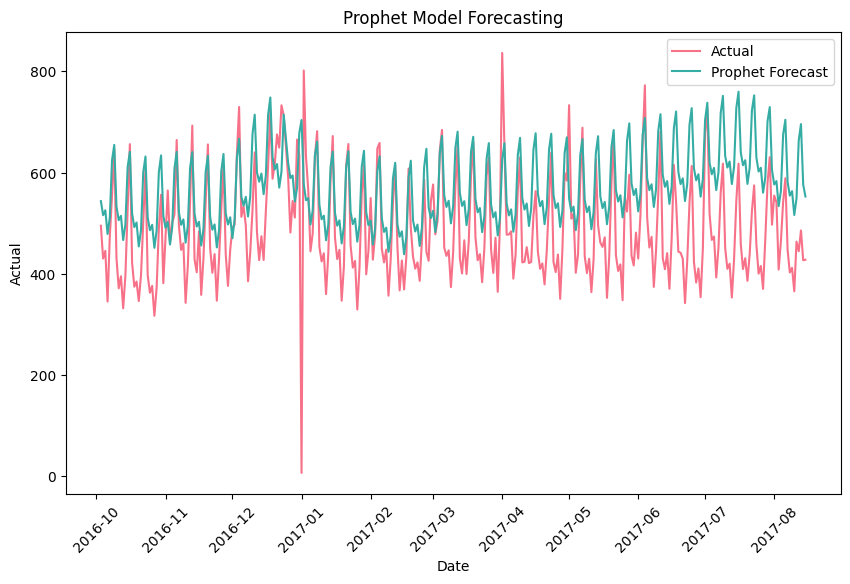

In [8]:
plot_predictions(model_df_test['ds'], model_df_test['y'], forecast['yhat'], 'Prophet Forecast', 'Prophet Model Forecasting')

# Prophet Model w/ all one hot encoded features

In [9]:
df_test_all = pd.read_pickle(path / 'df_test.pkl')
df_train_all = pd.read_pickle(path / 'df_train.pkl')

In [10]:
df_test_all.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'cluster',
       'familycluster', 'day_of_week', 'month', 'year', 'oil_price',
       'holiday_Carnaval', 'holiday_Dia de la Madre',
       'holiday_Dia del Trabajo', 'holiday_Fundacion de Quito',
       'holiday_Independencia de Cuenca',
       'holiday_Mundial de futbol Brasil: Ecuador-Suiza', 'holiday_Navidad-1',
       'holiday_Navidad-2', 'holiday_Navidad-3', 'holiday_Navidad-4',
       'holiday_Primer dia del ano', 'holiday_Terremoto Manabi+1',
       'holiday_Terremoto Manabi+2', 'holiday_Terremoto Manabi+3',
       'holiday_Terremoto Manabi+4', 'holiday_Terremoto Manabi+5',
       'holiday_Traslado Primer dia del ano'],
      dtype='object')

In [11]:
model_df_all = df_train_all
model_df_test_all = df_test_all
model_df_all.rename(columns = {'date':'ds'}, inplace = True)
model_df_all.rename(columns = {'sales':'y'}, inplace = True)
model_df_all['ds'] = pd.to_datetime(model_df_all['ds'])
model_df_test_all.rename(columns = {'date':'ds'}, inplace = True)
model_df_test_all.rename(columns = {'sales':'y'}, inplace = True)
model_df_test_all['ds'] = pd.to_datetime(model_df_test_all['ds'])

In [12]:
model_df_all

,id,ds,store_nbr,family,y,onpromotion,cluster,familycluster,day_of_week,month,...,holiday_Navidad-2,holiday_Navidad-3,holiday_Navidad-4,holiday_Primer dia del ano,holiday_Terremoto Manabi+1,holiday_Terremoto Manabi+2,holiday_Terremoto Manabi+3,holiday_Terremoto Manabi+4,holiday_Terremoto Manabi+5,holiday_Traslado Primer dia del ano
0,592,2013-01-01,25,SCHOOL AND OFFICE SUPPLIES,0.00,0.0,1,5,1,1,...,0,0,0,1,0,0,0,0,0,0
1,568,2013-01-01,25,CLEANING,186.00,0.0,1,5,1,1,...,0,0,0,1,0,0,0,0,0,0
2,569,2013-01-01,25,DAIRY,143.00,0.0,1,5,1,1,...,0,0,0,1,0,0,0,0,0,0
3,570,2013-01-01,25,DELI,71.09,0.0,1,5,1,1,...,0,0,0,1,0,0,0,0,0,0
4,571,2013-01-01,25,EGGS,46.00,0.0,1,5,1,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935982,2153099,2016-04-26,21,HARDWARE,1.00,0.0,6,4,1,4,...,0,0,0,0,0,0,0,0,0,0
1935983,2153248,2016-04-26,25,SCHOOL AND OFFICE SUPPLIES,0.00,0.0,1,5,1,4,...,0,0,0,0,0,0,0,0,0,0
1935984,2153249,2016-04-26,25,SEAFOOD,0.00,0.0,1,3,1,4,...,0,0,0,0,0,0,0,0,0,0
1935985,2153745,2016-04-26,4,AUTOMOTIVE,2.00,0.0,9,5,1,4,...,0,0,0,0,0,0,0,0,0,0


In [13]:
c = Prophet()
for i in model_df_all.drop(columns = ['ds', 'y']).columns:
    c.add_regressor(i)
c.fit(model_df_all)

ValueError: Unable to parse string "SCHOOL AND OFFICE SUPPLIES" at position 0

In [ ]:
forecast = c.predict(model_df_test_all.drop(columns="y"))

In [ ]:
evaluate_forecast(model_df_test_all['y'], forecast['yhat'])

# Prophet Model w/ family cat and store sales

In [5]:
df_test_p = pd.read_pickle(path / 'df_test_fb.pkl')
df_train_p = pd.read_pickle(path / 'df_train_fb.pkl')

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# # Apply label encoding to the 'family' column
# df_train_p['family_enc'] = label_encoder.fit_transform(df_train_p['family'])
# df_test_p['family_enc'] = label_encoder.fit_transform(df_test_p['family'])

model_df = df_train_p[['date', 'sales', 'family', 'store_nbr']]
model_df.columns = ['ds', 'y', 'family', 'store_nbr']
model_df['ds'] = pd.to_datetime(model_df['ds'])

model_df_test = df_test_p[['date', 'sales', 'family', 'store_nbr']]
model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

In [ ]:
m = Prophet()
for i in model_df.drop(columns = ['ds', 'y']).columns:
    print(i)
    m.add_regressor(i)
m.fit(model_df)

forecast = m.predict(model_df_test.drop(columns="y"))

evaluate_forecast(model_df_test['y'], forecast['yhat'])

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming df_train_p and df_test_p are already loaded

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'family' column
df_train_p['family_enc'] = label_encoder.fit_transform(df_train_p['family'])
df_test_p['family_enc'] = label_encoder.transform(df_test_p['family'])

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = {}
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

        m = Prophet()
        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        results[family] = evaluate_forecast(model_df_test['y'], forecast['yhat'])
    
    return results

# Define your evaluate_forecast function here

# Call the function to train and evaluate Prophet models for each family
results_by_family = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use results_by_family as needed


In [ ]:
results_by_family

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = []
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])

        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
        results.append((family, rmsle_value, len(test_family)))
    
    # Aggregate the results
    total_samples = sum([sample_count for _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, rmsle, sample_count in results])
    
    return weighted_rmsle

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = []
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])
        
        m = Prophet()
        m.add_country_holidays(country_name='EC')
        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x >= 0 else 0)
        rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
        results.append((family, rmsle_value, len(test_family)))
        print(forecast['yhat'].describe())
    
    # Aggregate the results
    total_samples = sum([sample_count for _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, rmsle, sample_count in results])
    
    return weighted_rmsle, results

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Ensure both forecast and y_test are numpy arrays
    y_test = np.array(y_test)
    forecast = np.array(forecast)

    # Remove any NaN values from the arrays
    y_test = y_test[~np.isnan(y_test)]
    forecast = forecast[~np.isnan(forecast)]

    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the RMSLE value
    return rmsle_value

# Define a function to train and evaluate Prophet model for each family
def train_and_evaluate_by_family(train_df, test_df):
    results = []
    unique_families = train_df['family'].unique()
    
    for family in unique_families:
        print("Processing family:", family)
        train_family = train_df[train_df['family'] == family]
        test_family = test_df[test_df['family'] == family]

        model_df = train_family[['date', 'sales', 'family', 'store_nbr']]
        model_df.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df['ds'] = pd.to_datetime(model_df['ds'])

        model_df_test = test_family[['date', 'sales', 'family', 'store_nbr']]
        model_df_test.columns = ['ds', 'y', 'family', 'store_nbr']
        model_df_test['ds'] = pd.to_datetime(model_df_test['ds'])
        
        m = Prophet()
        m.add_country_holidays(country_name='EC')
        m.add_regressor('store_nbr')
        m.fit(model_df)

        forecast = m.predict(model_df_test.drop(columns="y"))
        forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x >= 0 else 0)
        rmsle_value = evaluate_forecast(model_df_test['y'], forecast['yhat'])
        results.append((family, rmsle_value, len(test_family)))
        print(forecast['yhat'].describe())
    
    # Aggregate the results
    total_samples = sum([sample_count for _, _, sample_count in results])
    weighted_rmsle = sum([rmsle * (sample_count / total_samples) for _, rmsle, sample_count in results])
    
    return weighted_rmsle, results

# Call the function to train and evaluate Prophet models for each family
weighted_rmsle = train_and_evaluate_by_family(df_train_p, df_test_p)

# Print or use weighted_rmsle as needed
print("Weighted RMSLE:", weighted_rmsle)


In [22]:
df_train_p[df_train_p['family'] == "SCHOOL AND OFFICE SUPPLIES"].describe()

,sales,familycluster,store_nbr
count,67049.000000,67049.0,67049.000000
mean,2.225999,5.0,26.857940
std,14.913792,0.0,15.641041
min,0.000000,5.0,1.000000
25%,0.000000,5.0,13.000000
50%,0.000000,5.0,27.000000
75%,0.000000,5.0,40.000000
max,1217.000000,5.0,54.000000
